In [1]:
import os

from PIL import Image
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt

import random
import numpy as np

from torchvision.models import resnet18, ResNet18_Weights

import warnings
warnings.filterwarnings("ignore")

In [2]:
main_path = 'D:/Users/DELL/Desktop/Columbia/Adv_topics_DL/Project'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class DeWeatherDataset(Dataset):
    def __init__(self, input_dir, gt_dir, transform=None):
        self.input_dir = input_dir
        self.gt_dir = gt_dir
        self.transform = transform

        self.input_images = sorted(os.listdir(self.input_dir))
        self.gt_images = sorted(os.listdir(self.gt_dir))

        assert len(self.input_images) == len(self.gt_images), "Input and GT count mismatch!"

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_images[idx])
        gt_path = os.path.join(self.gt_dir, self.gt_images[idx])

        input_img = Image.open(input_path).convert('RGB')
        gt_img = Image.open(gt_path).convert('RGB')

        if self.transform:
            input_img = self.transform(input_img)
            gt_img = self.transform(gt_img)

        return input_img, gt_img


def get_dataloaders(batch_size=16, img_size=256, train_limit=2000, test_limit=1000):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

    rain_train_dataset = DeWeatherDataset(main_path + '/Data/rain/train/rainy', main_path + '/Data/rain/train/GT', transform=transform)
    rain_test_dataset = DeWeatherDataset(main_path + '/Data/rain/test/rainy', main_path + '/Data/rain/test/GT', transform=transform)

    haze_train_dataset = DeWeatherDataset(main_path + '/Data/haze/train/hazy', main_path + '/Data/haze/train/GT', transform=transform)
    haze_test_dataset = DeWeatherDataset(main_path + '/Data/haze/test/hazy', main_path + '/Data/haze/test/GT', transform=transform)

    def get_subset(dataset, limit):
        indices = list(range(len(dataset)))
        random.shuffle(indices)
        return Subset(dataset, indices[:limit])

    rain_train_dataset = get_subset(rain_train_dataset, train_limit // 2)
    haze_train_dataset = get_subset(haze_train_dataset, train_limit // 2)

    rain_test_dataset = get_subset(rain_test_dataset, test_limit // 2)
    haze_test_dataset = get_subset(haze_test_dataset, test_limit // 2)

    rain_train_loader = DataLoader(rain_train_dataset, batch_size=batch_size, shuffle=True)
    rain_test_loader = DataLoader(rain_test_dataset, batch_size=batch_size, shuffle=False)
    haze_train_loader = DataLoader(haze_train_dataset, batch_size=batch_size, shuffle=True)
    haze_test_loader = DataLoader(haze_test_dataset, batch_size=batch_size, shuffle=False)

    combined_train_dataset = ConcatDataset([rain_train_dataset, haze_train_dataset])
    combined_test_dataset = ConcatDataset([rain_test_dataset, haze_test_dataset])

    combined_train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
    combined_test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=False)

    return {
        'rain_train_loader': rain_train_loader,
        'rain_test_loader': rain_test_loader,
        'haze_train_loader': haze_train_loader,
        'haze_test_loader': haze_test_loader,
        'combined_train_loader': combined_train_loader,
        'combined_test_loader': combined_test_loader,
    }

In [4]:
###########################
# 1. Triplet Attention Block
###########################
class TripletAttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(TripletAttentionBlock, self).__init__()

        # Local Pixel-wise Attention (LPA)
        self.lpa = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

        # Global Strip-wise Attention (GSA)
        self.gsa_h = nn.Conv2d(in_channels, in_channels, kernel_size=(1, 3), padding=(0, 1))
        self.gsa_v = nn.Conv2d(in_channels, in_channels, kernel_size=(3, 1), padding=(1, 0))

        # Global Distribution Attention (GDA)
        self.gda_conv1 = nn.Conv2d(in_channels, in_channels // 2, kernel_size=1)
        self.gda_in = nn.InstanceNorm2d(in_channels // 2)
        self.gda_conv2 = nn.Conv2d(in_channels // 2 * 2, in_channels, kernel_size=1)

    def forward(self, x):
        # LPA
        lpa_map = self.lpa(x)

        # GSA
        gsa_h = self.gsa_h(x)
        gsa_v = self.gsa_v(x)
        gsa_map = torch.sigmoid(gsa_h + gsa_v)

        # Combine LPA and GSA
        spatial_attended = x * lpa_map * gsa_map

        # GDA
        gda1 = self.gda_in(self.gda_conv1(x))
        gda2 = self.gda_conv1(x)
        gda_cat = torch.cat([gda1, gda2], dim=1)
        gda_out = self.gda_conv2(gda_cat)

        return spatial_attended + gda_out + x

In [5]:
###########################
# 2. TANet Architecture
###########################
class TANet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(TANet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            TripletAttentionBlock(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            TripletAttentionBlock(128),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            TripletAttentionBlock(64),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
class EfficientUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(EfficientUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

In [7]:
def psnr(pred, target, max_val=1.0):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(max_val / torch.sqrt(mse))

In [8]:
classifier = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
classifier.fc = nn.Linear(classifier.fc.in_features, 2)

state_dict = torch.load("classifier.pth", map_location=torch.device('cpu'))
classifier.load_state_dict(state_dict)

classifier.to(torch.device('cpu'))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
de_raining_model = EfficientUNet().to(device)
de_raining_model.load_state_dict(torch.load('de-raining.pth', map_location=device))

<All keys matched successfully>

In [10]:
de_hazing_model = EfficientUNet().to(device)
de_hazing_model.load_state_dict(torch.load('de-hazing.pth', map_location=device))

<All keys matched successfully>

In [11]:
TANet = TANet().to(device)
TANet.load_state_dict(torch.load('TANet.pth', map_location=device))

<All keys matched successfully>

In [12]:
loaders = get_dataloaders(batch_size=8, img_size=256)
test_loader = loaders['combined_test_loader']
rain_test_loader = loaders['rain_test_loader']
haze_test_loader = loaders['haze_test_loader']

In [13]:
def evaluate_and_visualize(TANet, classifier, de_raining_model, de_hazing_model, dataloader, save_dir, img_type=""):
    os.makedirs(save_dir, exist_ok=True)
    
    # Set all models to evaluation mode
    TANet.eval()
    classifier.eval()
    de_raining_model.eval()
    de_hazing_model.eval()

    psnr_tanet = []
    psnr_modular = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # TANet inference
            outputs_tanet = TANet(inputs)

            # Modular inference
            predictions = classifier(inputs).argmax(dim=1)  # assume binary: 0 = rain, 1 = haze
            outputs_modular = torch.zeros_like(inputs)
            for i in range(inputs.size(0)):
                if predictions[i] == 0:
                    outputs_modular[i] = de_raining_model(inputs[i].unsqueeze(0)).squeeze(0)
                else:
                    outputs_modular[i] = de_hazing_model(inputs[i].unsqueeze(0)).squeeze(0)

            # PSNR calculation
            for i in range(inputs.size(0)):
                psnr_tanet.append(psnr(outputs_tanet[i], targets[i]).item())
                psnr_modular.append(psnr(outputs_modular[i], targets[i]).item())

        # Visualization on first batch
        inputs, targets = next(iter(dataloader))
        inputs, targets = inputs.to(device), targets.to(device)
        outputs_tanet = TANet(inputs)

        predictions = classifier(inputs).argmax(dim=1)
        outputs_modular = torch.zeros_like(inputs)
        for i in range(inputs.size(0)):
            if predictions[i] == 0:
                outputs_modular[i] = de_raining_model(inputs[i].unsqueeze(0)).squeeze(0)
            else:
                outputs_modular[i] = de_hazing_model(inputs[i].unsqueeze(0)).squeeze(0)

        for i in range(min(8, inputs.size(0))):
            comparison = torch.cat([
                inputs[i],
                outputs_tanet[i],
                outputs_modular[i],
                targets[i]
            ], dim=2)
            img_path = f"{save_dir}/{img_type}_compare_sample_{i}.png"
            vutils.save_image(comparison, img_path, normalize=True)

            img = mpimg.imread(img_path)
            plt.figure(figsize=(8, 2))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{img_type.title()} Sample {i}\n[Input | TANet | Modular | Target]")
            plt.show()

        print(f"Saved sample comparison images to `{save_dir}`.")

    # PSNR reporting
    avg_psnr_tanet = np.mean(psnr_tanet)
    avg_psnr_modular = np.mean(psnr_modular)
    print(f"Average PSNR on test set - TANet: {avg_psnr_tanet:.2f} dB")
    print(f"Average PSNR on test set - Modular: {avg_psnr_modular:.2f} dB")

    # Histogram
    plt.figure(figsize=(8, 4))
    plt.hist(psnr_tanet, bins=20, alpha=0.7, label='TANet', color='skyblue', edgecolor='black')
    plt.hist(psnr_modular, bins=20, alpha=0.7, label='Modular', color='salmon', edgecolor='black')
    plt.title(f'PSNR Distribution - {img_type.title()}')
    plt.xlabel('PSNR (dB)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    hist_path = f"{save_dir}/{img_type}_psnr_comparison.png"
    plt.savefig(hist_path)
    print(f"Saved PSNR comparison histogram to '{hist_path}'")

In [14]:
comp_dir_1 = main_path + '/comparison-combined'
comp_dir_2 = main_path + '/comparison-rain'
comp_dir_3 = main_path + '/comparison-haze'

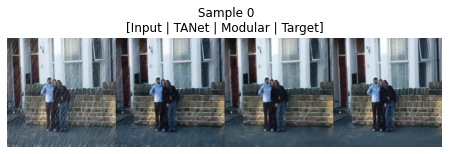

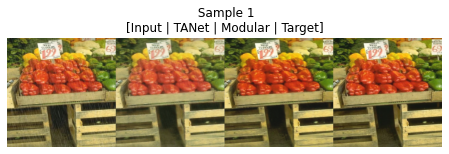

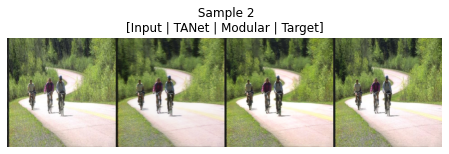

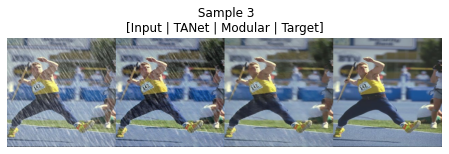

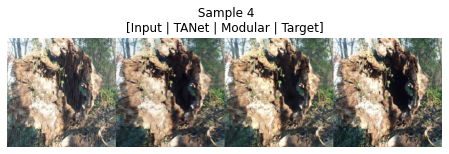

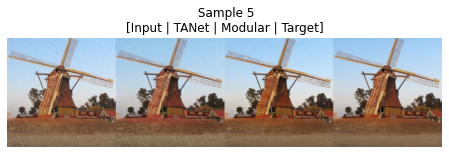

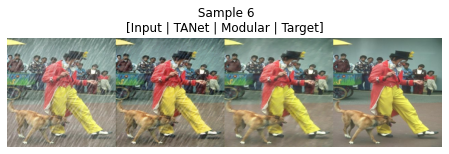

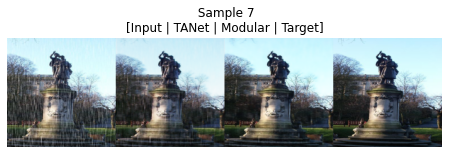

Saved sample comparison images to `D:/Users/DELL/Desktop/Columbia/Adv_topics_DL/Project/comparison-combined`.
Average PSNR on test set - TANet: 25.12 dB
Average PSNR on test set - Modular: 24.40 dB
Saved PSNR comparison histogram to 'D:/Users/DELL/Desktop/Columbia/Adv_topics_DL/Project/comparison-combined/_psnr_comparison.png'


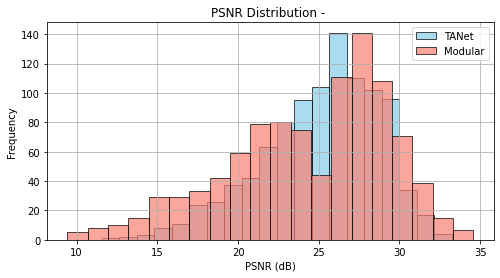

In [15]:
evaluate_and_visualize(TANet, classifier, de_raining_model, de_hazing_model, test_loader, comp_dir_1, img_type="")

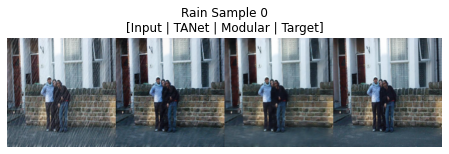

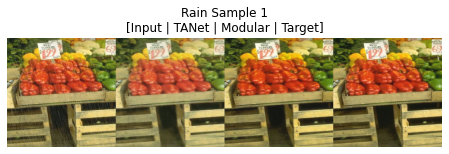

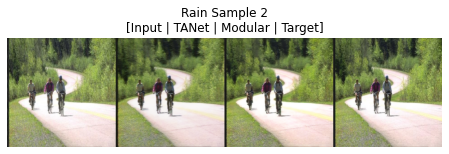

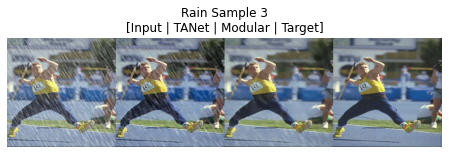

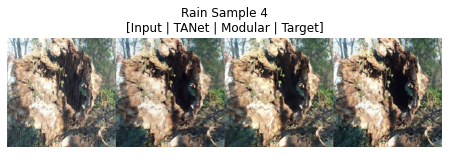

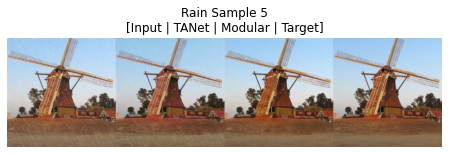

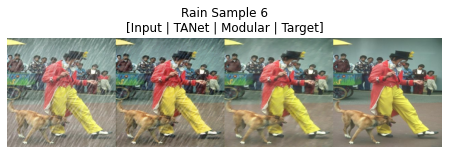

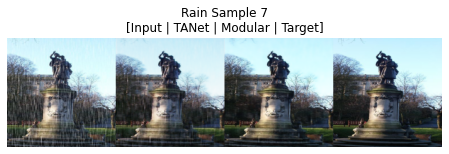

Saved sample comparison images to `D:/Users/DELL/Desktop/Columbia/Adv_topics_DL/Project/comparison-rain`.
Average PSNR on test set - TANet: 27.10 dB
Average PSNR on test set - Modular: 28.28 dB
Saved PSNR comparison histogram to 'D:/Users/DELL/Desktop/Columbia/Adv_topics_DL/Project/comparison-rain/rain_psnr_comparison.png'


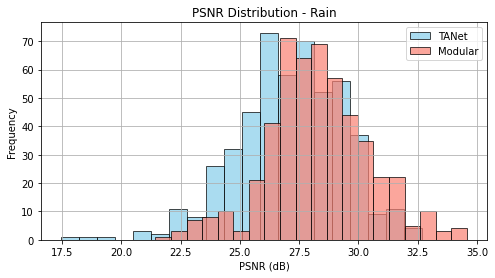

In [16]:
evaluate_and_visualize(TANet, classifier, de_raining_model, de_hazing_model, rain_test_loader, comp_dir_2, img_type="rain")

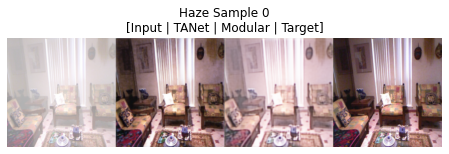

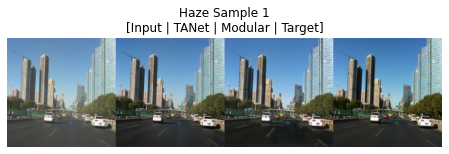

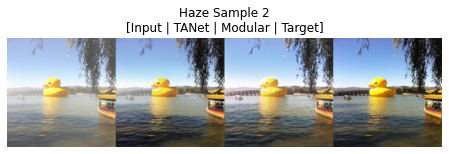

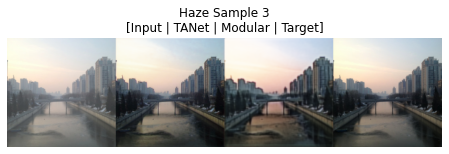

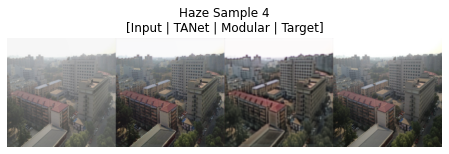

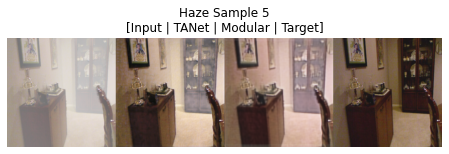

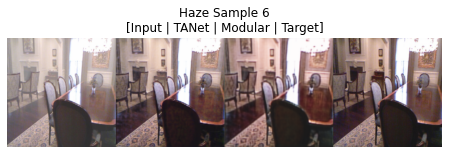

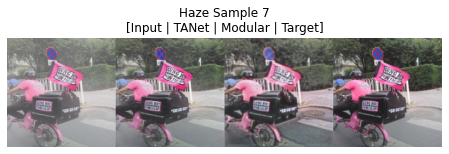

Saved sample comparison images to `D:/Users/DELL/Desktop/Columbia/Adv_topics_DL/Project/comparison-haze`.
Average PSNR on test set - TANet: 23.13 dB
Average PSNR on test set - Modular: 20.51 dB
Saved PSNR comparison histogram to 'D:/Users/DELL/Desktop/Columbia/Adv_topics_DL/Project/comparison-haze/haze_psnr_comparison.png'


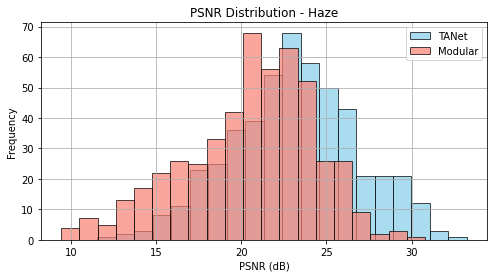

In [17]:
evaluate_and_visualize(TANet, classifier, de_raining_model, de_hazing_model, haze_test_loader, comp_dir_3, img_type="haze")